In [30]:
import geopandas as gpd
import rasterio
from rasterio.plot import reshape_as_image

import requests
import folium
from folium.plugins import HeatMap
from folium.raster_layers import ImageOverlay

In [55]:
ignition_path = "./data/sierra_nevada_geoms/sierra_nevada_fire_ignitions.geojson"
perimeter_path = "./data/sierra_nevada_geoms/sierra_nevada_fire_ignitions.geojson"
utility_path = "./data/sierra_nevada_geoms/sierra_nevada_utility_lines.geojson"
sierra_nevada_shape_path = "./utils/sierra_nevada_boundary.geojson"
geoserver_url = "https://sparcal.sdsc.edu/geoserver/rrk_sn/wms?"
#?service=WMS&version=1.1.0&request=GetMap&layers=rrk_sn%3A{0}&bbox=-189989.99999999814%2C-326400.0%2C202890.00000000186%2C442800.0&width=392&height=768&srs=EPSG%3A3310&styles=&format=image%2Ftiff"

In [42]:
above_carbon_url = 'https://sparcal.sdsc.edu/geoserver/rrk_sn/wms?service=WMS&version=1.1.0&request=GetMap&layers=rrk_sn%3AF3_AbovegroundLiveTreeCarbon_2021&bbox=-189989.99999999814%2C-326400.0%2C202890.00000000186%2C442800.0&width=392&height=768&srs=EPSG%3A3310&styles=&format=image%2Ftiff'

In [43]:
above_carbon_url

'https://sparcal.sdsc.edu/geoserver/rrk_sn/wms?service=WMS&version=1.1.0&request=GetMap&layers=rrk_sn%3AF3_AbovegroundLiveTreeCarbon_2021&bbox=-189989.99999999814%2C-326400.0%2C202890.00000000186%2C442800.0&width=392&height=768&srs=EPSG%3A3310&styles=&format=image%2Ftiff'

In [16]:
above_carbon_url = geoserver_url.format("F3_AbovegroundLiveTreeCarbon_2021")
#geoserver_url.format(tiff_name)

/tmp/ipykernel_146/833094334.py:1: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  ignition_df.buffer(500).unary_union


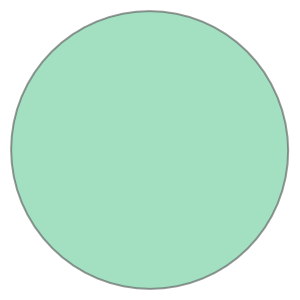

In [3]:
ignition_df = gpd.read_file(ignition_path).to_crs(epsg=4326)
perimeter_df = gpd.read_file(perimeter_path).to_crs(epsg=4326)
utility_df = gpd.read_file(utility_path).to_crs(epsg=4326)
sierra_nevada_shape = gpd.read_file(sierra_nevada_shape_path).to_crs(epsg=4326).loc[0, 'geometry']

In [31]:
with rasterio.open("./data/rrk_sn-F3_AbovegroundLiveTreeCarbon_2021.tif") as img:
    data = img.read()
print(data)

[[[255 255 255 ... 255 255 255]
  [255 255 255 ... 255 255 255]
  [255 255 255 ... 255 255 255]
  ...
  [255 255 255 ... 255 255 255]
  [255 255 255 ... 255 255 255]
  [255 255 255 ... 255 255 255]]]


/srv/starter_content/_User-Persistent-Storage_/wired-utility/lib/python3.12/site-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


In [74]:
center = sierra_nevada_shape.centroid
map_center = [center.y, center.x]
m = folium.Map(location=map_center, zoom_start=8)

raster_layer = folium.raster_layers.WmsTileLayer(
    url = geoserver_url,
    layers='rrk_sn:F3_TotalCarbon_2021_30m',
    attr='Tile attribution',
    name='Raster Layer',
    transparent=True,
    overlay=True,
    control=True,
    fmt="image/png8",
    #tiled=True,
)
raster_layer.add_to(m)


utility_layer = folium.GeoJson(utility_df, name="Transmission Lines")
utility_layer.add_to(m)

ignition_df['LATITUDE'] = ignition_df.geometry.y
ignition_df['LONGITUDE'] = ignition_df.geometry.x
ignition_coords = ignition_df[['LATITUDE', 'LONGITUDE']].values.tolist()
ignition_heatmap_layer = HeatMap(ignition_coords, name="Ignition Points")
ignition_heatmap_layer.add_to(m)



folium.LayerControl().add_to(m)

In [75]:
m